In [6]:
import librosa
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm #pip install dqtm

In [7]:
#all belows are for a single time stamp

def autocorrelationfunction(audio, window, time_start, tau) -> np.float64:
    # sum(xj * x(j+tau)) for j from t+1 to t+w
    return np.sum(
        audio[time_start : time_start + window] *
        audio[tau + time_start : tau + time_start + window]
    )

def DF(audio, window, time_start, tau) -> np.float64:
    # d(tau) = sum ((xj - x(j+tau))**2) for j from t+1 to t+w
    # (xj - x(j+tau))**2 decompose into xj**2 - 2(xj*x(j+tau)) +x(j+tau)**2
    return autocorrelationfunction(audio, window, time_start, 0)\
        - (2 * autocorrelationfunction(audio, window, time_start, tau))\
        + autocorrelationfunction(audio, window, time_start + tau, 0)

def CMNDF(audio, window, time_start, tau):
    #normalization
    if tau == 0:
        return 1
    return DF(audio, window, time_start, tau)\
        / np.sum([DF(audio, window, time_start, j + 1) for j in range(tau)]) * tau

def detect_pitch_CMNDF(audio, fs, window, time, bounds, dp_th):
    #for frequency range from lower bound and upper bound
    #   for tau from f0Max to the f0Min
    CMNDF_vals = [CMNDF(audio, window, time, i) for i in range(bounds[1], bounds[0])] #o(n^2)
    sample = None
    for i, val in enumerate(CMNDF_vals):
        if val < dp_th:
            sample = i
            break
    if sample is None:
        sample = np.argmin(CMNDF_vals)

    return fs / sample

def memo_CMNDF(audio, window, time, lag_max):
    running_sum = 0
    vals = []
    for lag in range(0, lag_max):
        if lag == 0:
            vals.append(1)
            running_sum += 0
        else:
            running_sum += DF(audio, window, time, lag)
            vals.append(DF(audio, window, time, lag) / running_sum * lag)
    return vals


def augmented_detect_pitch_CMNDF(audio, fs, window, time, bounds, dp_th=0.1):  # Also uses memoization
    CMNDF_vals = memo_CMNDF(audio, window, time, bounds[0])

    rms = np.sqrt(np.sum(audio[time:time+window]**2)) * (1/window)
    sample = None
    for i, val in enumerate(CMNDF_vals, 1):
        if val < dp_th:
            sample = i
            break
    if sample is None:
        return 0, rms
    new_sample = sample
    if sample < (len(CMNDF_vals)-1) and sample != 0:
        new_sample = sample - ((CMNDF_vals[sample+1] - CMNDF_vals[sample-1]) / 2*(CMNDF_vals[sample-1] + CMNDF_vals[sample+1] - 2*CMNDF_vals[sample]))

    
    return (fs / (new_sample)), rms


In [8]:
def myYin(waveData, fs, tHop=0.01, tW=0.025, f0Min=40, f0Max=400, dp_th=0.1):
    assert tHop <= tW, "incorrect size of stride"
    window_size = int(tW * fs)
    step_size = int(tHop * fs)
    bounds = [1000, 25]
    pitches = []
    d_primes = []
    rmses = []

    print(f'total audio length: {waveData.shape[0]}, window size of {window_size}, each window step size is {step_size}, search for tau between {bounds[1]} and {bounds[0]}')

    iteration = int(1 + ((waveData.shape[0]-window_size-bounds[0]) // step_size))
    zero_paddings = int((iteration*step_size+window_size+bounds[0]) - waveData.shape[0])
    waveData = np.append(waveData, np.zeros(zero_paddings))
    
    print('waveData after padding is ', waveData.shape[0])
    for i in tqdm(range(iteration)): #1254
        pitch, rms = augmented_detect_pitch_CMNDF(
                waveData,
                fs,
                window_size,
                i * step_size,
                bounds,
                dp_th
            )
        pitches.append(pitch)
        if(pitch == 0):
            d_primes.append(0)
        else:
            d_primes.append(fs / pitch)
        rmses.append(rms)
    return np.array(pitches), np.array(d_primes), np.array(rmses)


In [9]:
def evalSinglePitch(pEst, pGt, freqDevTh=0.03):
    shortest = min(pEst.shape[0], pGt.shape[0])
    pGt, pEst = pGt[:shortest], pEst[:shortest]
    count = 0
    nC = 0
    nE = 0
    for pE, pG in zip(pEst, pGt):
        #skip zeros
        if pE == 0 or pG == 0:
            continue
        else:
            count += 1
            if (np.abs(pE - pG) / pG) <= freqDevTh:
                nC += 1
            else:
                nE += 1
    Acc = nC/(count + count - nC)
    Pre = nC / nE
    Recall = nC/pGt.shape[0]
    return Acc, Pre, Recall
    

total audio length: 176400, window size of 1023, each window step size is 220, search for tau between 25 and 1000
waveData after padding is  176483


100%|██████████| 793/793 [00:11<00:00, 67.33it/s]


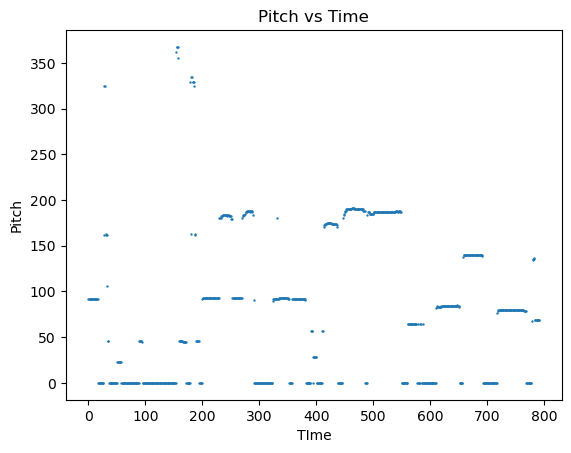

total audio length: 176400, window size of 1023, each window step size is 220, search for tau between 25 and 1000
waveData after padding is  176483


100%|██████████| 793/793 [00:11<00:00, 66.67it/s]


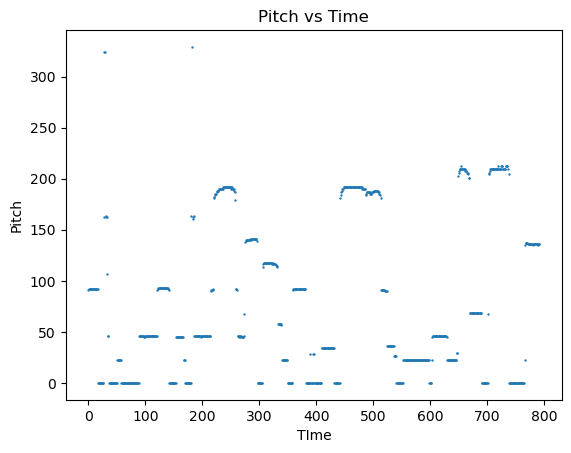

total audio length: 176400, window size of 1023, each window step size is 220, search for tau between 25 and 1000
waveData after padding is  176483


100%|██████████| 793/793 [00:11<00:00, 67.30it/s]


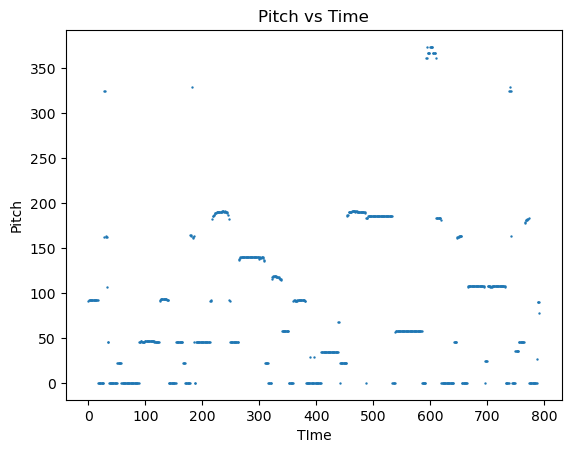

In [10]:
audio, fs = librosa.load('/Users/roywang/Schools/Project/DDPM_for_Audio/audios/interpolation_extend_5_sec.wav')
audio_2, fs_2 = librosa.load('/Users/roywang/Schools/Project/DDPM_for_Audio/audios/resampling_extend_5_sec.wav')
audio_3, fs_3 = librosa.load('/Users/roywang/Schools/Project/DDPM_for_Audio/audios/resampling_real_extend_5_sec.wav')
#helpers
def graph(input, xlabel, ylabel, title):
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.scatter(np.arange(input.shape[0]),input, s=0.5)
    plt.show()


pitch, _, _ = myYin(audio, fs, 0.01, 0.0464, 40, 2000, 0.1)
graph(pitch, 'TIme', 'Pitch', 'Pitch vs Time')
pitch2, _, _ = myYin(audio_2, fs_2, 0.01, 0.0464, 40, 2000, 0.1)
graph(pitch2, 'TIme', 'Pitch', 'Pitch vs Time')
pitch3, _, _ = myYin(audio_3, fs_3, 0.01, 0.0464, 40, 2000, 0.1)
graph(pitch3, 'TIme', 'Pitch', 'Pitch vs Time')